In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from keras.preprocessing import image

In [2]:
p = Path('../../Scripts/MultiClassClassification/Images')

dirs = p.glob("*")
label_dict = {'cat': 0, 'dog': 1, 'horse': 2, 'Human': 3}
image_data = []
labels = []
for folder_dir in dirs:
    label = str(folder_dir).split('\\')[-1][:-1]
    
    for img_path in folder_dir.glob('*.jpg'):
        img = image.load_img(img_path, target_size=((32, 32)))
        img_arr = image.img_to_array(img)
        image_data.append(img_arr)
        labels.append(label_dict[label])

image_data = np.asarray(image_data, dtype='float32')/255.0
labels = np.asarray(labels)
print(image_data)

[[[[0.12941177 0.14509805 0.15686275]
   [0.15294118 0.17254902 0.15686275]
   [0.12941177 0.16470589 0.16078432]
   ...
   [0.28235295 0.30980393 0.4117647 ]
   [0.36862746 0.39607844 0.49803922]
   [0.7058824  0.69411767 0.627451  ]]

  [[0.14901961 0.16470589 0.1764706 ]
   [0.16470589 0.18431373 0.16862746]
   [0.16862746 0.20392157 0.2       ]
   ...
   [0.29411766 0.3254902  0.4       ]
   [0.30588236 0.3372549  0.4117647 ]
   [0.7176471  0.69411767 0.5921569 ]]

  [[0.12156863 0.15686275 0.15294118]
   [0.13725491 0.17254902 0.16862746]
   [0.14509805 0.18039216 0.1764706 ]
   ...
   [0.30588236 0.34509805 0.39215687]
   [0.2901961  0.33333334 0.35686275]
   [0.68235296 0.654902   0.58431375]]

  ...

  [[0.0627451  0.0627451  0.0627451 ]
   [0.06666667 0.06666667 0.06666667]
   [0.05098039 0.05098039 0.05098039]
   ...
   [0.34117648 0.28627452 0.2509804 ]
   [0.37254903 0.31764707 0.27450982]
   [0.12941177 0.07058824 0.05098039]]

  [[0.09411765 0.09411765 0.09411765]
   [0.0

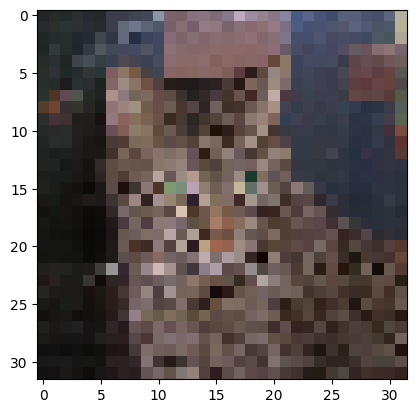

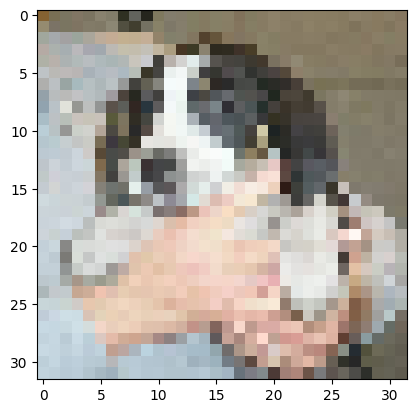

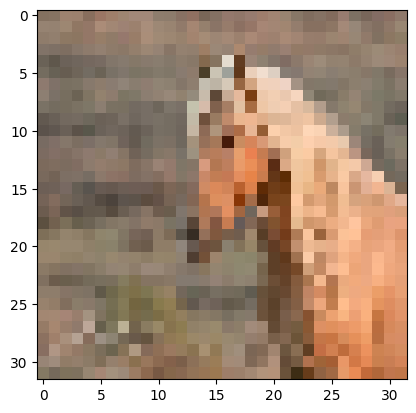

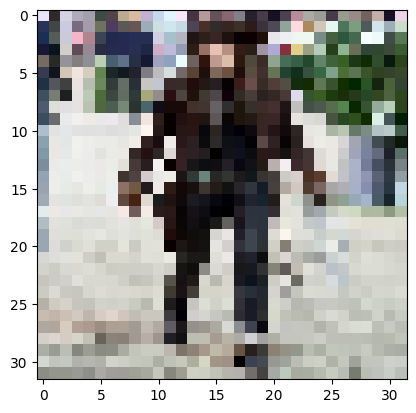

In [3]:
plt.imshow(image_data[0])
plt.show()
plt.imshow(image_data[203])
plt.show()
plt.imshow(image_data[503])
plt.show()
plt.imshow(image_data[703])
plt.show()

In [4]:
import random
combined = list(zip(image_data, labels))
random.shuffle(combined)
image_data[:], labels[:] = zip(*combined)

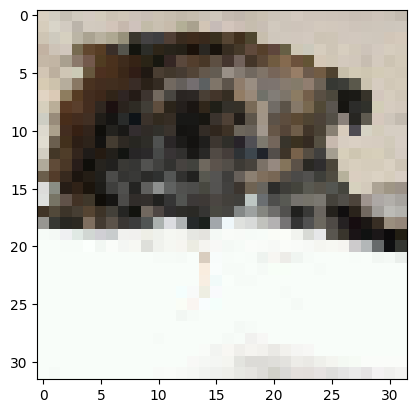

In [5]:
plt.imshow(image_data[4])

### Convert this binary classification into 1 vs 1 classification

In [6]:
class SVM:
    def __init__(self, C=1.0):
        self.C = C
        self.W = 0
        self.b = 0

    def hingeLoss(self, W, b, X, Y):
        loss = 0.5 * np.dot(W, W.T)
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i] * (np.dot(W, X[i].T) + b)
            loss += self.C * max(0, 1 - ti)

        return loss[0,0]
    
    def fit(self, X, Y, batch_size=100, alpha=0.001, maxIters=300):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        c = self.C
        w = np.zeros((1, no_of_features))
        bias = 0

        losses = []
        for i in range(maxIters):
            l = self.hingeLoss(w, bias, X, Y)
            losses.append(l)

            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            for batch_start in range(0, no_of_samples, batch_size):
                gradb = 0
                gradw = 0
                for j in range(batch_start, batch_start + batch_size):
                    if j < no_of_samples:
                        k = ids[j]
                        ti = Y[k] * (np.dot(w, X[k].T) + bias)
                        if ti >= 1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c * Y[k] * X[k]
                            gradb += c * Y[k]
                
                bias += alpha * gradb
                w = w - alpha * w + alpha * gradw

        self.b = bias
        self.W = w
        return self.b, self.W[0], losses

In [7]:
M = image_data.shape[0]
image_data = image_data.reshape((M, -1))
print(image_data.shape)
print(labels.shape)

(808, 3072)
(808,)


In [8]:
classes = len(np.unique(labels))
def classWiseData(x, y):
    data = {}
    for i in range(classes):
        data[i] = []

    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
    for k in data.keys():
        data[k] = np.array(data[k])
    return data

data = classWiseData(image_data, labels)
data[0].shape[0]

202

In [9]:
def getDataPairforSVM(d1, d2):
    l1, l2 = d1.shape[0], d2.shape[0]
    samples = l1 + l2
    features = d1.shape[1]

    data_pairs = np.zeros((samples, features))
    data_lables = np.zeros((samples, ))

    data_pairs[:l1, :] = d1
    data_pairs[l1:, :] = d2

    data_lables[:l1] = -1
    data_lables[l1:] = +1
    return data_pairs, data_lables

In [10]:
mysvm = SVM()

In [11]:
def trainSVMs(x,y):
    svm_classifiers={}
    for i in range(classes):
        svm_classifiers[i]={}
        for j in range(i+1,classes):
            xpair,ypair = getDataPairforSVM(data[i],data[j])
            wts,b,loss = mysvm.fit(xpair,ypair,alpha=0.00001,maxIters=1000)
            svm_classifiers[i][j]=(wts,b)
            
            plt.plot(loss)
            plt.show()
            
    return svm_classifiers  

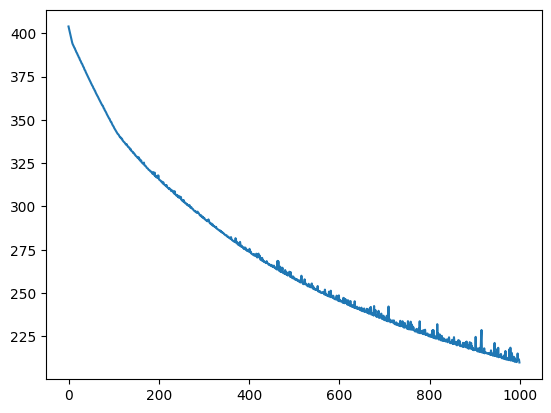

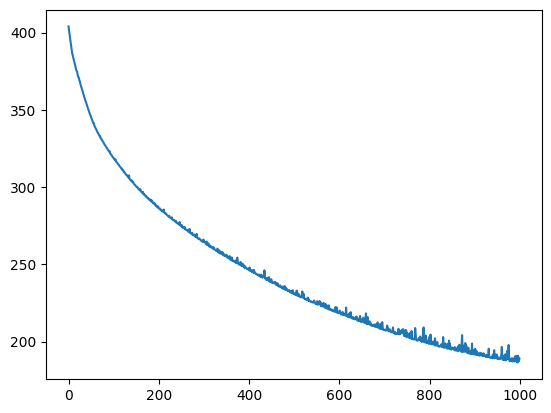

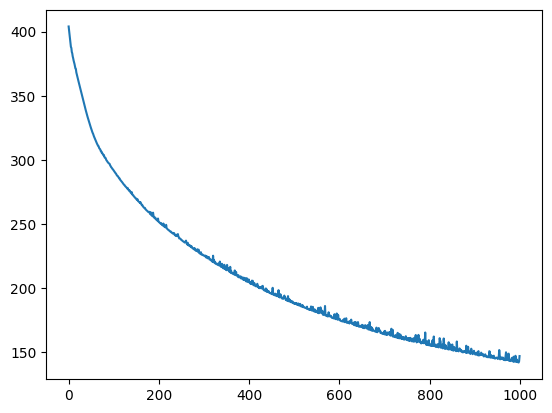

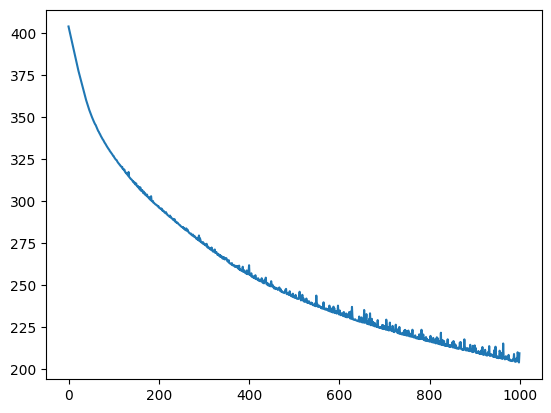

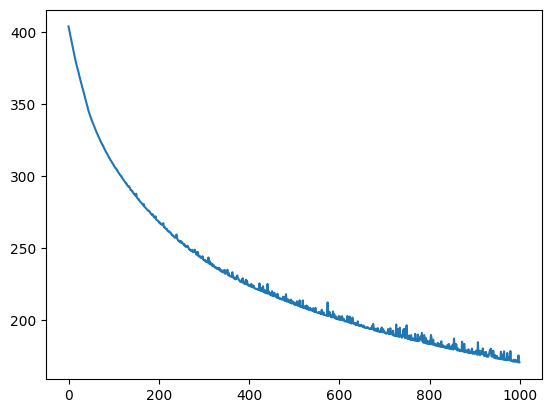

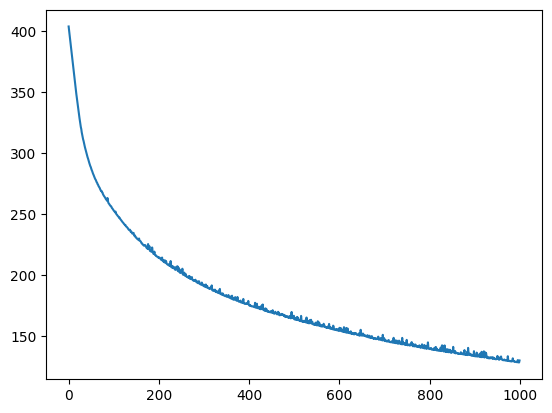

In [12]:
svm_classifiers = trainSVMs(image_data, labels)

In [13]:
cat_dog = svm_classifiers[0][1]
cat_humans = svm_classifiers[0][3]
cat_humans

(-0.03395999999999995,
 array([0.04388756, 0.04734657, 0.04995596, ..., 0.03448445, 0.04709414,
        0.04273752]))

In [14]:
def binaryPredict(x, w, b):
    z = np.dot(w, x.T) + b
    if z >= 0:
        return 1
    return -1

In [21]:
def predict(x):
    count = np.zeros((classes,))
    
    for i in range(classes):
        for j in range(i+1,classes):
            b, w = svm_classifiers[i][j]
            z=binaryPredict(x,w,b)
            
            if (z==1):
                count[j]+=1
            else:
                count[i]+=1
    final_predictions = np.argmax(count)           
    return final_predictions

In [22]:
print(predict(image_data[2]))
print(labels[2])

0
2


In [23]:
def score(x, y):
    cnt = 0
    for i in range(x.shape[0]):
        cnt += (y[i] == predict(x[i]))
    print(cnt / y.shape[0])
score(image_data, labels)

0.6089108910891089


In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
params = [
    {
        'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
        'C': [0.1, 0.5, 0.3, 1.0, 2.0, 3.0, 5.0]
    }
]
svc = svm.SVC()
gs = GridSearchCV(svc, param_grid=params, scoring='accuracy', n_jobs=8, cv=5)
gs.fit(image_data, labels)
# svc.fit(image_data, labels)
# svc.score(image_data, labels)

In [ ]:
gs.score(image_data, labels)

In [ ]:
gs.estimator